In [1]:
import pandas as pd

In [2]:
from neuralforecast import NeuralForecast

# Load and preprocess your dataset
Y_df = pd.read_csv('../data/average_weekly_rating_snapchat.csv')

# Ensure the 'ds' column is datetime
Y_df['ds'] = pd.to_datetime(Y_df.iloc[:, 0])

# Ensure the 'y' column is numeric and handle any non-numeric issues
Y_df['y'] = pd.to_numeric(Y_df.iloc[:, 1], errors='coerce')
Y_df.dropna(subset=['y'], inplace=True)  # Drop rows where 'y' is NaN after conversion

# Add unique_id as a constant value
Y_df['unique_id'] = 'rating'

# Keep only necessary columns
Y_df = Y_df[['unique_id', 'ds', 'y']]

# Check the DataFrame to confirm structure and types
print(Y_df.dtypes)  # 'unique_id' should be object, 'ds' datetime64, 'y' float64
print(Y_df.head())

unique_id            object
ds           datetime64[ns]
y                   float64
dtype: object
  unique_id         ds         y
0    rating 2020-01-05  4.250000
1    rating 2020-01-12  4.066667
2    rating 2020-01-19  3.789474
3    rating 2020-01-26  3.687500
4    rating 2020-02-02  3.300000


In [3]:
# Define validation and test sizes
n_time = len(Y_df['ds'].unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)

In [4]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Autoformer, PatchTST

In [5]:
horizon = 48  # Forecasting 1 years

models = [
    Autoformer(h=horizon,
               input_size=horizon,
               max_steps=200,
               val_check_steps=50,
               early_stop_patience_steps=3),
    PatchTST(h=horizon,
             input_size=horizon,
             max_steps=200,
             val_check_steps=50,
             early_stop_patience_steps=3),
]

Seed set to 1
Seed set to 1


In [6]:
nf = NeuralForecast(
    models=models,
    freq='W'  # Weekly frequency for your dataset
)

Y_hat_df = nf.cross_validation(
    df=Y_df,
    val_size=val_size,
    test_size=test_size,
    n_windows=None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=200` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 437 K  | train
-----------------------------------------------------------
437 K     Trainable params
3         Non-trainable params
437 K     Total params
1.749     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=200` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
Y_hat_df.head()

,ds,cutoff,Autoformer,PatchTST,y
unique_id,,,,,
rating,2023-11-26,2023-11-19,3.646194,3.552357,1.133333
rating,2023-12-03,2023-11-19,3.443601,3.957886,1.444444
rating,2023-12-10,2023-11-19,3.918417,3.770219,1.142857
rating,2023-12-17,2023-11-19,3.361638,3.000838,1.000000
rating,2023-12-24,2023-11-19,3.957043,2.986952,1.027027


In [8]:
import matplotlib.pyplot as plt

In [9]:
from neuralforecast.losses.numpy import mae

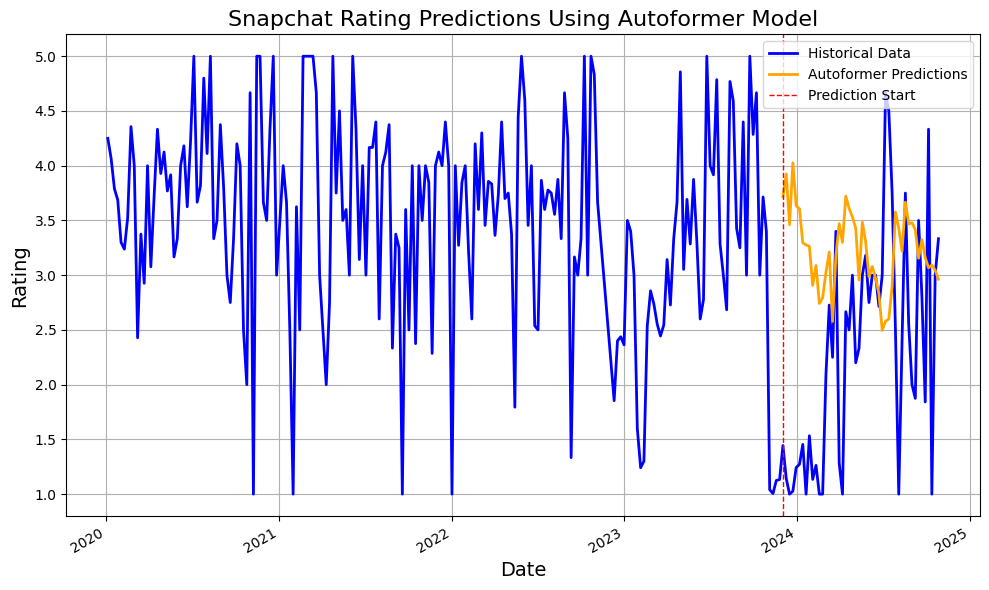

In [10]:
import matplotlib.pyplot as plt

# Get the latest cutoff for filtering predictions
latest_cutoff = Y_hat_df['cutoff'].max()
Y_hat_filtered = Y_hat_df[Y_hat_df['cutoff'] == latest_cutoff]

# Plot the results (both historical data and filtered future predictions)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot historical data
Y_df.set_index('ds')['y'].plot(ax=ax, label='Historical Data', color='blue', linewidth=2)

# Plot filtered future predictions from the latest cutoff in cross-validation results
Y_hat_filtered.set_index('ds')['Autoformer'].plot(ax=ax, label='Autoformer Predictions', color='orange', linewidth=2)

# Predict zone
prediction_start_date = Y_hat_filtered['ds'].min() 
plt.axvline(x=prediction_start_date, color='red', linestyle='--', linewidth=1, label='Prediction Start')

# Formatting the plot
ax.set_title('Snapchat Rating Predictions Using Autoformer Model', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)

ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.show()

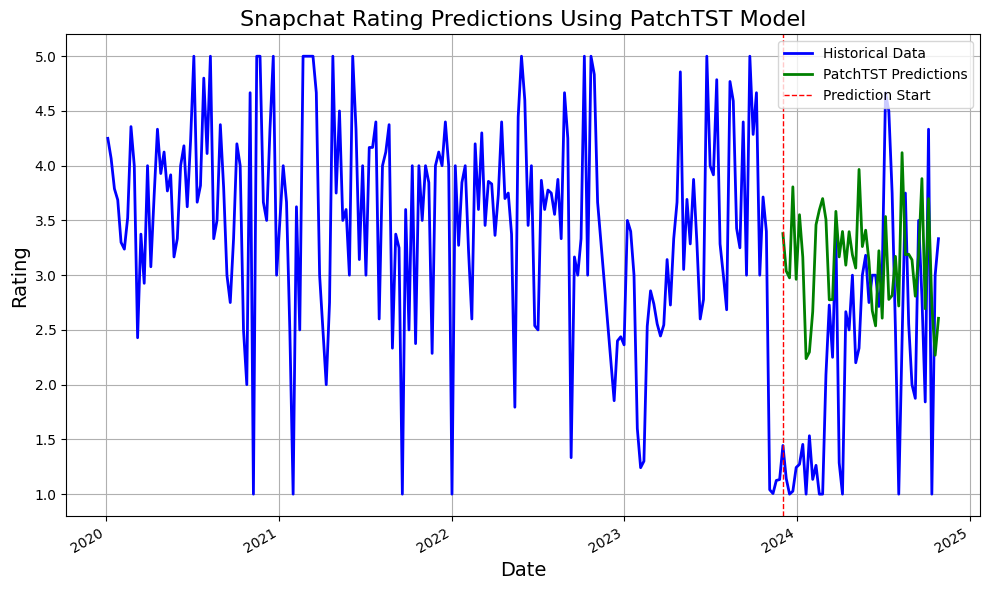

In [11]:
import matplotlib.pyplot as plt

# Get the latest cutoff for filtering predictions
latest_cutoff = Y_hat_df['cutoff'].max()
Y_hat_filtered = Y_hat_df[Y_hat_df['cutoff'] == latest_cutoff]

# Plot the results (both historical data and filtered future predictions)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot historical data
Y_df.set_index('ds')['y'].plot(ax=ax, label='Historical Data', color='blue', linewidth=2)

# Plot filtered future predictions from the latest cutoff in cross-validation results
Y_hat_filtered.set_index('ds')['PatchTST'].plot(ax=ax, label='PatchTST Predictions', color='green', linewidth=2)

# Predict zone
prediction_start_date = Y_hat_filtered['ds'].min() 
plt.axvline(x=prediction_start_date, color='red', linestyle='--', linewidth=1, label='Prediction Start')

# Formatting the plot
ax.set_title('Snapchat Rating Predictions Using PatchTST Model', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)

ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.show()

In [17]:
from neuralforecast.losses.numpy import mae
import numpy as np

# Define RSE and MRSE functions
def rse(y_true, y_pred):
    """Root Squared Error"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mrse(y_true, y_pred):
    """Mean Root Squared Error"""
    return np.mean(np.sqrt((y_true - y_pred) ** 2))

# Calculate MAE, RSE, and MRSE for Autoformer
mae_autoformer = mae(Y_hat_df['y'], Y_hat_df['Autoformer'])
rse_autoformer = rse(Y_hat_df['y'], Y_hat_df['Autoformer'])
mrse_autoformer = mrse(Y_hat_df['y'], Y_hat_df['Autoformer'])

# Calculate MAE, RSE, and MRSE for PatchTST
mae_patchtst = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])
rse_patchtst = rse(Y_hat_df['y'], Y_hat_df['PatchTST'])
mrse_patchtst = mrse(Y_hat_df['y'], Y_hat_df['PatchTST'])

# Print the results
print(f'Autoformer - MAE: {mae_autoformer:.3f}, RSE: {rse_autoformer:.3f}, MRSE: {mrse_autoformer:.3f}')
print(f'PatchTST - MAE: {mae_patchtst:.3f}, RSE: {rse_patchtst:.3f}, MRSE: {mrse_patchtst:.3f}')

Autoformer - MAE: 1.266, RSE: 1.524, MRSE: 1.266
PatchTST - MAE: 1.208, RSE: 1.435, MRSE: 1.208


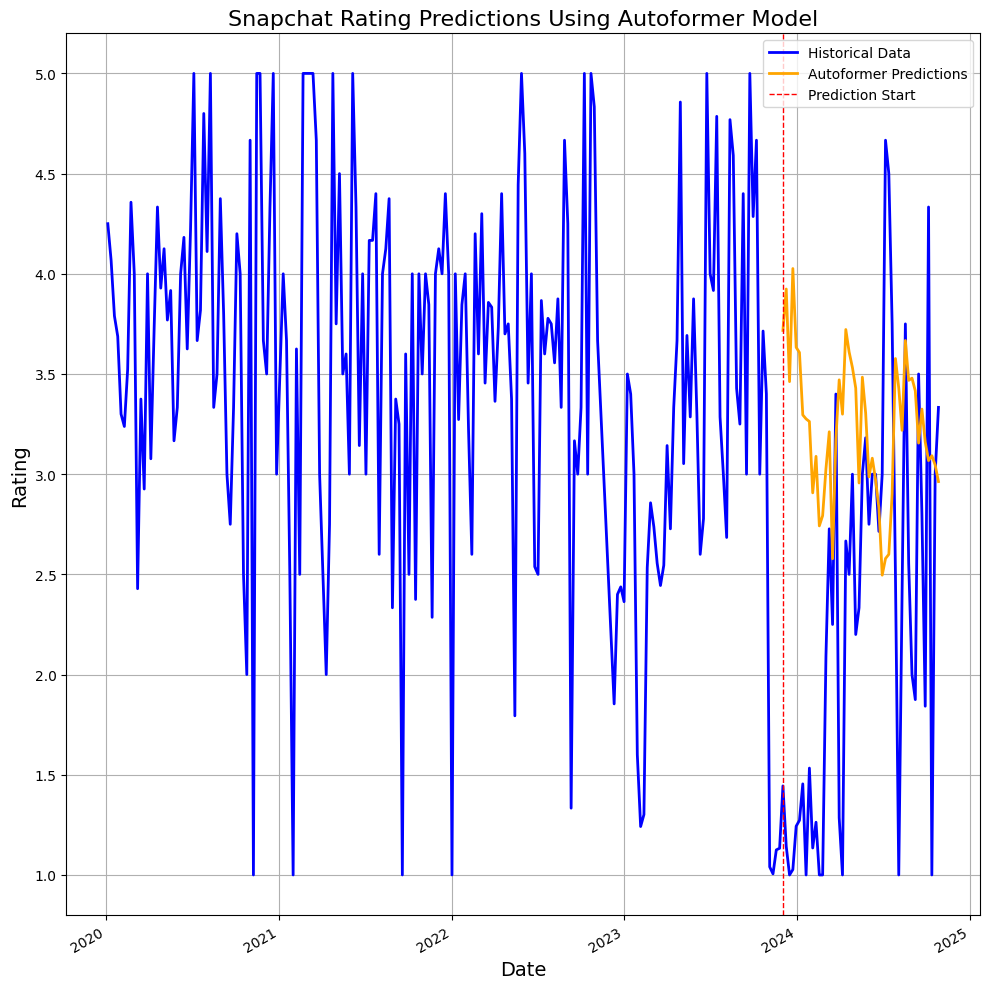

In [18]:
# Square plot for article
latest_cutoff = Y_hat_df['cutoff'].max()
Y_hat_filtered = Y_hat_df[Y_hat_df['cutoff'] == latest_cutoff]
fig, ax = plt.subplots(figsize=(10, 10))
Y_df.set_index('ds')['y'].plot(ax=ax, label='Historical Data', color='blue', linewidth=2)
Y_hat_filtered.set_index('ds')['Autoformer'].plot(ax=ax, label='Autoformer Predictions', color='orange', linewidth=2)

prediction_start_date = Y_hat_filtered['ds'].min() 
plt.axvline(x=prediction_start_date, color='red', linestyle='--', linewidth=1, label='Prediction Start')

ax.set_title('Snapchat Rating Predictions Using Autoformer Model', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)

ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.show()

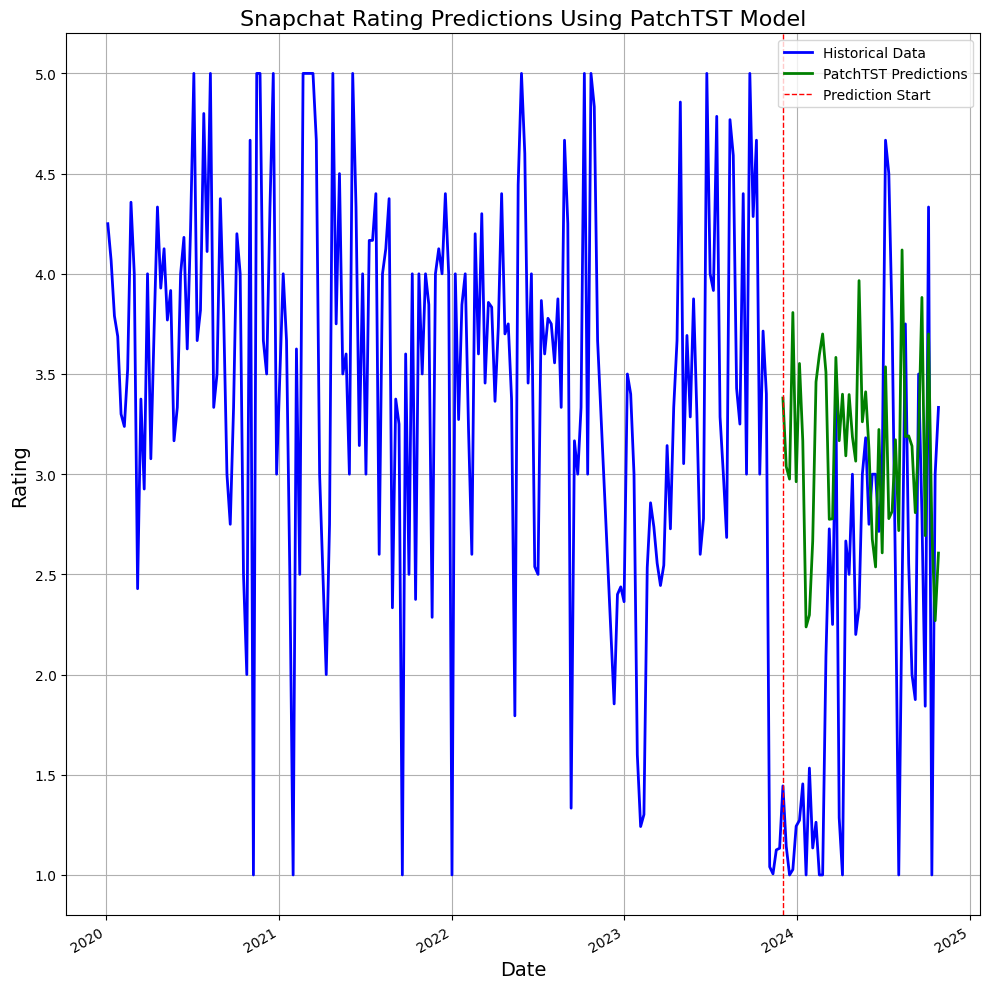

In [19]:
# Square plot for article
latest_cutoff = Y_hat_df['cutoff'].max()
Y_hat_filtered = Y_hat_df[Y_hat_df['cutoff'] == latest_cutoff]
fig, ax = plt.subplots(figsize=(10, 10))
Y_df.set_index('ds')['y'].plot(ax=ax, label='Historical Data', color='blue', linewidth=2)
Y_hat_filtered.set_index('ds')['PatchTST'].plot(ax=ax, label='PatchTST Predictions', color='green', linewidth=2)

prediction_start_date = Y_hat_filtered['ds'].min() 
plt.axvline(x=prediction_start_date, color='red', linestyle='--', linewidth=1, label='Prediction Start')

ax.set_title('Snapchat Rating Predictions Using PatchTST Model', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rating', fontsize=14)

ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()
plt.show()